# VQA Model

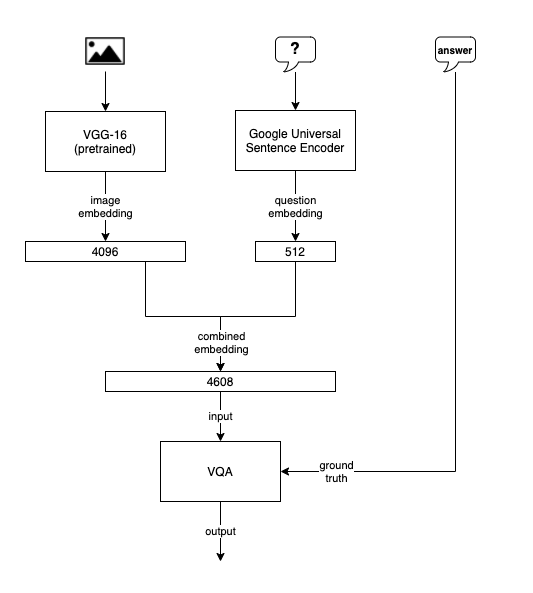

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage import io
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import json
import pprint
import numpy as np
import time
from datetime import timedelta


Mounting shared Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import sys
sys.path.append('/content/drive/My Drive/aidl/lib')

Mounted at /content/drive


In [ ]:
! ls -1 '/content/drive/My Drive/aidl/coco/'*.jpg | wc -l

18152


Global Parameters

In [ ]:
batch_size = 30
num_epochs = 20
learning_rate = 0.001
#dataset_root = "/content/model1000_any"
#dataset_root = "/content/drive/My Drive/aidl"
#dataset_root = "/content/drive/My Drive/aidl/Dataset100"
#dataset_root = "/content/drive/My Drive/aidl/model5000_1_20"
#dataset_root = "/content/drive/My Drive/aidl/model10000_1_20"
dataset_root = "/content/drive/My Drive/aidl/model1000_any"
#dataset_root = "/content/drive/My Drive/aidl/model10000_yes_no"

!ls '$dataset_root'
device = torch.device('cuda')

annotations.save       mscoco_a.json	 mscoco_qtrain.txt
coco		       mscoco_i.txt	 question_embeddings.save
image_embeddings.save  mscoco_q.json
metadatas.save	       mscoco_qtest.txt


In [ ]:
#!mkdir "model1000_any"
#!cp -r "/content/drive/My Drive/aidl/model1000_any" "model1000_any"
#!cp "/content/drive/My Drive/aidl/coco"/*.jpg /content/model1000_any/coco
!ls -la /content/model1000_any

total 15844
drwxr-xr-x 3 root root     4096 Nov 11 16:36 .
drwxr-xr-x 1 root root     4096 Nov 11 16:32 ..
-rw------- 1 root root     6708 Nov 11 16:33 annotations.save
lrwxrwxrwx 1 root root       33 Nov 11 16:33 coco -> '/content/drive/My Drive/aidl/coco'
-rw------- 1 root root 12288756 Nov 11 16:33 image_embeddings.save
drwxr-xr-x 2 root root     4096 Nov 11 16:36 .ipynb_checkpoints
-rw------- 1 root root   107951 Nov 11 16:33 metadatas.save
-rw------- 1 root root  1641295 Nov 11 16:33 mscoco_a.json
-rw------- 1 root root    38000 Nov 11 16:33 mscoco_i.txt
-rw------- 1 root root   564933 Nov 11 16:33 mscoco_q.json
-rw------- 1 root root     1946 Nov 11 16:33 mscoco_qtest.txt
-rw------- 1 root root     5850 Nov 11 16:33 mscoco_qtrain.txt
-rw------- 1 root root  1536756 Nov 11 16:33 question_embeddings.save


Custom Data Loader

In [ ]:
"""
     Data structure:

     root_dir
        |_ mscoco_qtrain.txt [list of question IDs for training]
        |_ mscoco_qtest.txt  [list of question IDs for testing]
        |_ mscoco_q.json     [json of questions]
        |_ mscoco_a.json     [json of annotations]
        |_ coco              [subdirectory for images]
            |_ image 1
            |_ image 2
              ...
            |_ image n

"""

class TestDataset(Dataset):
#
#   _ _ i n i t _ _
#
    def __init__(self, root_dir, train=False, transform=None):
        """
        Args:
            root_dir (string): root directory for the data           
            train (bool, optional): choose training or testing datasets
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        super().__init__()

        # Define some constants to access files
        self.image_prefix = "COCO_val2014_"
        self.image_postfix = ".jpg"
        self.image_subdir = 'coco'
        self.questions_list_train_fname = 'mscoco_qtrain.txt'
        self.questions_list_test_fname = 'mscoco_qtest.txt'
        self.questions_fname = 'mscoco_q.json'
        self.annotations_fname = 'mscoco_a.json'

        # Store parameters as class attributes
        self.root_dir = root_dir
        self.train = train
        self.transform = transform

        # Load questions json file
        fqfname = os.path.join(self.root_dir, self.questions_fname)
        self.questions = json.load(open(fqfname, 'r'))

        # Load annotations json file
        fqfname = os.path.join(self.root_dir, self.annotations_fname)
        self.annotations = json.load(open(fqfname, 'r'))

        # Compute list of unique answers (train + test)
        fqfname = os.path.join(self.root_dir, self.questions_list_train_fname)
        with open(fqfname) as f:
          tmp = f.read().splitlines()
        ql_train = list(map(int, tmp))

        fqfname = os.path.join(self.root_dir, self.questions_list_test_fname)
        with open(fqfname) as f:
          tmp = f.read().splitlines()
        ql_test = list(map(int, tmp))

        ql_global = set(ql_train + ql_test)

        self.annotation_map = {}
        self.annotation_classdist = {}
        annotation_id = 0
        for a in self.annotations:
            if a['question_id'] in ql_global:
                if not(a['multiple_choice_answer'] in self.annotation_map):
                    self.annotation_map[a['multiple_choice_answer']] = annotation_id
                    annotation_id += 1
                self.annotation_classdist.update({a['multiple_choice_answer'] : self.annotation_classdist.get(a['multiple_choice_answer'],0) + 1})

        #print (self.annotation_map)
        #print (self.annotation_classdist)

        print("Dataset: training {} / testing {}".format(len(ql_train), len(ql_test)))

        # Depending on self.train, assign either training question list or
        #   testing question list
        if (self.train):
            self.questions_list = ql_train
        else:
            self.questions_list = ql_test
#
#   _ _ l e n _ _
#
    def __len__(self):
        return len(self.questions_list)
#
#   _ _ g e t i t e m _ _
#
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get question_id from the list
        question_id = self.questions_list[idx]

        # Find corresponding question and annotation
        #   (use next() to get a single value from the list comprehension)
        question = next(x for x in self.questions if x['question_id'] == question_id)
        annotation = next(a for a in self.annotations if a['question_id'] == question_id)

        image_id = question['image_id']
        file_name = self.image_prefix+("0"*12+str(image_id))[-12:]+self.image_postfix
        fqfname = os.path.join(self.root_dir,self.image_subdir,file_name)
        image = Image.open(fqfname)
 
        # Fix B&W images
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply transformation if there is any
        if self.transform:
            image = self.transform(image)

        # Translate annotation to its ID
        annotation_ID = self.annotation_map[annotation['multiple_choice_answer']]

        # return tuple: image, question text, answer text
        return image, question['question'], annotation_ID

Image Embeddings (pretrained VGG-16)

In [ ]:
from torchvision import models, transforms

model = models.vgg16(pretrained=True)
model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import torch.nn as nn
class ImageEmbedding(nn.Module):

    def __init__(self, base_model):
        super().__init__()
        self.features = base_model.features
        self.avgpool = base_model.avgpool
        self.classifier = base_model.classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        for i, layer in enumerate(self.classifier):
            x = layer(x)
            if i == 3:
                break
        return x


Text Embeddings (Google Universal Sentence Encoder)

In [ ]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import re

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

sentence_embedding_generator = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


VQA Model

In [ ]:
import torch.nn.functional as F
"""
class VQAm1(nn.Module):
    def __init__(self, D_in, H, D_out):
        super().__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.batchnorm1 = nn.BatchNorm1d(num_features=H)
        self.dropout1 = torch.nn.Dropout(p=0.5)
        self.linear2 = torch.nn.Linear(H, H)
        self.batchnorm2 = nn.BatchNorm1d(num_features=H)
        self.dropout2 = torch.nn.Dropout(p=0.5)
        self.linear3 = torch.nn.Linear(H, D_out)
#        self.classifier = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        h_relu =  F.relu(self.linear1(x))
        h_relu = self.batchnorm1(h_relu)
        h_relu = self.dropout1(h_relu)
        h_relu =  F.relu(self.linear2(h_relu))
        h_relu = self.batchnorm2(h_relu)
        h_relu = self.dropout2(h_relu)
        y_pred = self.linear3(h_relu)
#        r = self.classifier(y_pred)
        return y_pred #r
"""
class VQAm1(nn.Module):
    def __init__(self, D_in, H, D_out):
        super().__init__()
        self.linear1 = torch.nn.Linear(D_in, 2*H)
        self.batchnorm1 = nn.BatchNorm1d(num_features=2*H,track_running_stats=False)
        self.dropout1 = torch.nn.Dropout(p=0.5)
        self.linear2 = torch.nn.Linear(2*H, H)
        self.batchnorm2 = nn.BatchNorm1d(num_features=H,track_running_stats=False)
        self.dropout2 = torch.nn.Dropout(p=0.5)
        self.linear3 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu =  F.relu(self.linear1(x))
        h_relu = self.batchnorm1(h_relu)
        h_relu = self.dropout1(h_relu)
        h_relu =  F.relu(self.linear2(h_relu))
        h_relu = self.batchnorm2(h_relu)
        h_relu = self.dropout2(h_relu)
        y_pred = self.linear3(h_relu)

        return y_pred

Training VQA Model

In [ ]:
# Execute an evaluation using test data

def evaluation(model,loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for batch, (image, question, annotation) in enumerate(loader):
    #        print("-->", annotation)
            annotation = annotation.to(device)
            image = image.to(device)
            image_embedding = image_embedding_extractor.forward(image)
            image_embedding = F.normalize(image_embedding)
    #   image_embedding.shape) = torch.Size([batch_size, 4096])
            question_embedding = sentence_embedding_generator(question).numpy()
            question_embedding = t(question_embedding)
            question_embedding = question_embedding.squeeze_(0).to(device)
    #   question_embedding.shape = torch.Size([batch_size, 512])
            combined_embedding = torch.cat((image_embedding,question_embedding),dim=1)
    #   combined_embedding.shape) = torch.Size([batch_size, 4608])
            combined_embedding = combined_embedding.to(device)

            y_pred = model(combined_embedding)
            _, results = torch.max(y_pred, 1)

            loss = criterion(y_pred, annotation)

            correct += (results == annotation).sum().item()
            total += annotation.size(0)
#           print("Correct {}/{}".format((results == annotation).sum().item(),annotation.size(0)))


    return 100 * correct / total, loss


In [ ]:
img_size = 512

transform = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                            ])

# Create Dataset & Dataloader
ds = TestDataset(dataset_root,train=True,transform=transform)
dl = DataLoader(ds,batch_size=batch_size,shuffle=True,num_workers=4)

test_dataset = TestDataset(dataset_root,train=False,transform=transform)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)

# Instantiate VQAmodel
VQAmodel = VQAm1(4608,128,len(ds.annotation_map))
VQAmodel.to(device)

image_embedding_extractor = ImageEmbedding(model)
for p in image_embedding_extractor.parameters():
    p.requires_grad = False
t = transforms.ToTensor()

#w = torch.tensor([sum(ds.annotation_classdist.values())/v for v in ds.annotation_classdist.values()])
#w.true_divide_(sum(w))
#w = w.to(device)

#criterion = torch.nn.CrossEntropyLoss(weight=w)
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(VQAmodel.parameters(), lr=1e-4)
optimizer = torch.optim.AdamW(VQAmodel.parameters(),lr=learning_rate)

iteration = 1
iters = []
losses = []
accur = []
epoch_e_accur = []
epoch_e_loss = []
start_time = time.time()
for epoch in range(num_epochs):
    VQAmodel.train()
    epoch_accur = []
    epoch_loss = []
    epoch_start_time = time.time()
    for batch, (image, question, annotation) in enumerate(dl):
        batch_start_time = time.time()
#        print("-->", annotation)
#        annotation = torch.tensor([int(i)-1 for i in annotation]).to(device)
        annotation = annotation.to(device)
        image = image.to(device)
        image_embedding = image_embedding_extractor.forward(image)
        image_embedding = F.normalize(image_embedding)
#   image_embedding.shape) = torch.Size([batch_size, 4096])
        question_embedding = sentence_embedding_generator(question).numpy()
        question_embedding = t(question_embedding)
        question_embedding = question_embedding.squeeze_(0).to(device)
#   question_embedding.shape = torch.Size([batch_size, 512])
        combined_embedding = torch.cat((image_embedding,question_embedding),dim=1)
#   combined_embedding.shape = torch.Size([batch_size, 4608])
        combined_embedding = combined_embedding.to(device)

        y_pred = VQAmodel.forward(combined_embedding)

        loss = criterion(y_pred, annotation)
        
#   Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #information on progress
        _, results = torch.max(y_pred, 1)
        accuracy = 100*sum(results == annotation).true_divide(len(annotation))

        iters.append(iteration)
        #losses.append(float(loss)/annotation.size(0))
        epoch_accur.append(accuracy)
        epoch_loss.append(float(loss))
        if (iteration % 10 == 0):
            print ("Epoch {:3d} Batch {:3d} Loss: {:6.4f} {:3.1f}% ({:3d})".format(epoch,batch,float(loss),sum(epoch_accur)/len(epoch_accur), annotation.size(0)))

        iteration += 1

    accur.append(sum(epoch_accur)/len(epoch_accur))
    losses.append(sum(epoch_loss)/len(epoch_loss))
    e_acc, e_loss = evaluation(VQAmodel,test_loader)
    epoch_e_accur.append(e_acc)
    epoch_e_loss.append(e_loss)
    epoch_end_time = time.time()
    #if (iteration % batch_size == 0):
    print ("Epoch {:3d} Evaluation acc :{:3.1f}% Duration: {}".format(epoch,e_acc,
                                                                   str(timedelta(seconds=int(epoch_end_time - epoch_start_time)))))

end_time = time.time()

print ("Total elapsed time : {}".format(str(timedelta(seconds=end_time - start_time))))
print("{} samples in {:,.0f} seconds : {:4.1f} samples/sec".format(len(ds)*num_epochs,end_time-start_time,len(ds)*num_epochs/(end_time-start_time)))




Dataset: training 750 / testing 250
Dataset: training 750 / testing 250
Epoch   0 Batch   9 Loss: 6.1142 1.0% ( 30)
Epoch   0 Batch  19 Loss: 5.5175 3.2% ( 30)
Epoch   0 Evaluation acc :12.4% Duration: 0:00:34
Epoch   1 Batch   4 Loss: 5.1512 14.7% ( 30)
Epoch   1 Batch  14 Loss: 4.6833 18.7% ( 30)
Epoch   1 Batch  24 Loss: 4.2672 20.8% ( 30)
Epoch   1 Evaluation acc :16.4% Duration: 0:00:32
Epoch   2 Batch   9 Loss: 3.9604 31.0% ( 30)
Epoch   2 Batch  19 Loss: 3.7336 32.2% ( 30)
Epoch   2 Evaluation acc :21.2% Duration: 0:00:32
Epoch   3 Batch   4 Loss: 4.0827 32.7% ( 30)
Epoch   3 Batch  14 Loss: 3.3904 37.1% ( 30)
Epoch   3 Batch  24 Loss: 3.1232 37.5% ( 30)
Epoch   3 Evaluation acc :22.4% Duration: 0:00:32
Epoch   4 Batch   9 Loss: 3.0776 41.0% ( 30)
Epoch   4 Batch  19 Loss: 2.8949 40.5% ( 30)
Epoch   4 Evaluation acc :22.4% Duration: 0:00:32
Epoch   5 Batch   4 Loss: 3.0913 37.3% ( 30)
Epoch   5 Batch  14 Loss: 3.1419 39.8% ( 30)
Epoch   5 Batch  24 Loss: 2.9972 40.4% ( 30)
Epoch

In [ ]:
epoch_e_loss

[tensor(5.2308, device='cuda:0'),
 tensor(4.4549, device='cuda:0'),
 tensor(3.6423, device='cuda:0'),
 tensor(3.4742, device='cuda:0'),
 tensor(3.5241, device='cuda:0')]

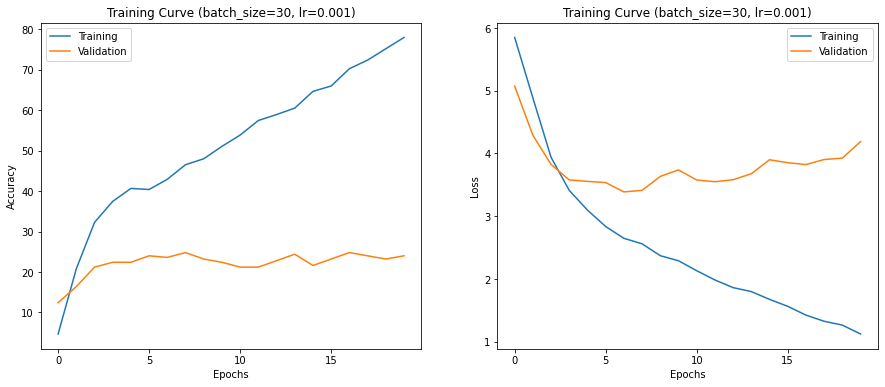

In [ ]:
# plotting
fig, ax = plt.subplots(1,2,figsize=(15, 6))
ax[0].set_title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
ax[0].plot(accur, label="Training")
ax[0].plot(epoch_e_accur, label="Validation")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_xticks(range(0,num_epochs,5))
ax[0].set_xticklabels(range(0,num_epochs,5))
ax[0].legend()

ax[1].set_title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
ax[1].plot(losses, label="Training")
ax[1].plot(epoch_e_loss, label="Validation")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_xticks(range(0,num_epochs,5))
ax[1].set_xticklabels(range(0,num_epochs,5))
ax[1].legend()
plt.show()

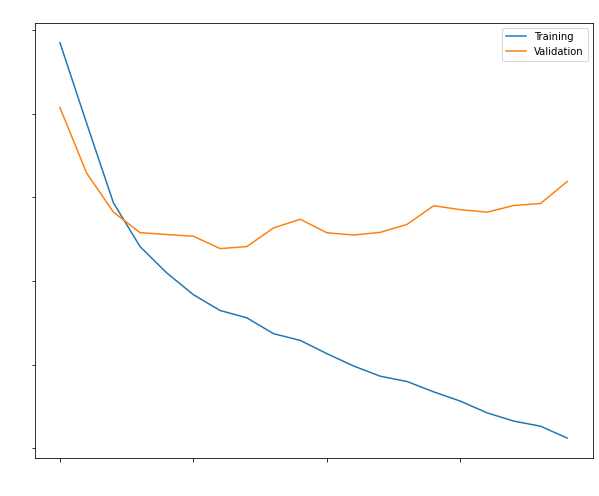

In [ ]:
# plotting
plt.figure(figsize=(10, 8))
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate),color='white')
plt.plot(losses, label="Training")
plt.plot(epoch_e_loss, label="Validation")
plt.xlabel("Epochs",color='white')
plt.ylabel("Loss",color='white')
plt.xticks(range(0,19,5),color='white')
plt.yticks(color='white')
plt.legend()
plt.show()

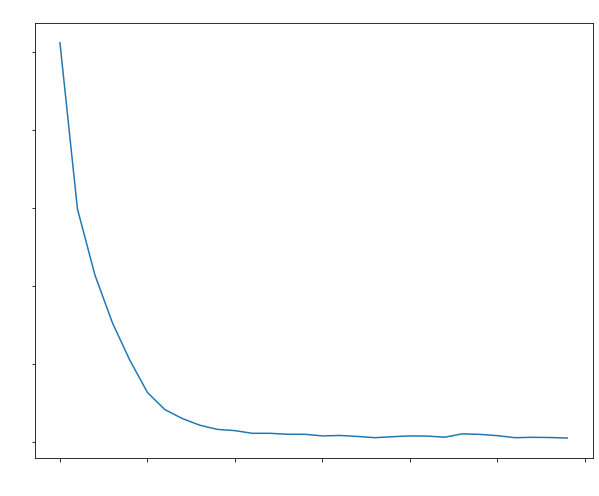

In [ ]:
# plotting
plt.figure(figsize=(10, 8))
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate),color='white')
plt.plot( losses, label="Train")
plt.xlabel("Epochs",color='white')
plt.ylabel("Loss",color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

Dataset visual check

Dataset: training 7500 / testing 250


NameError: ignored

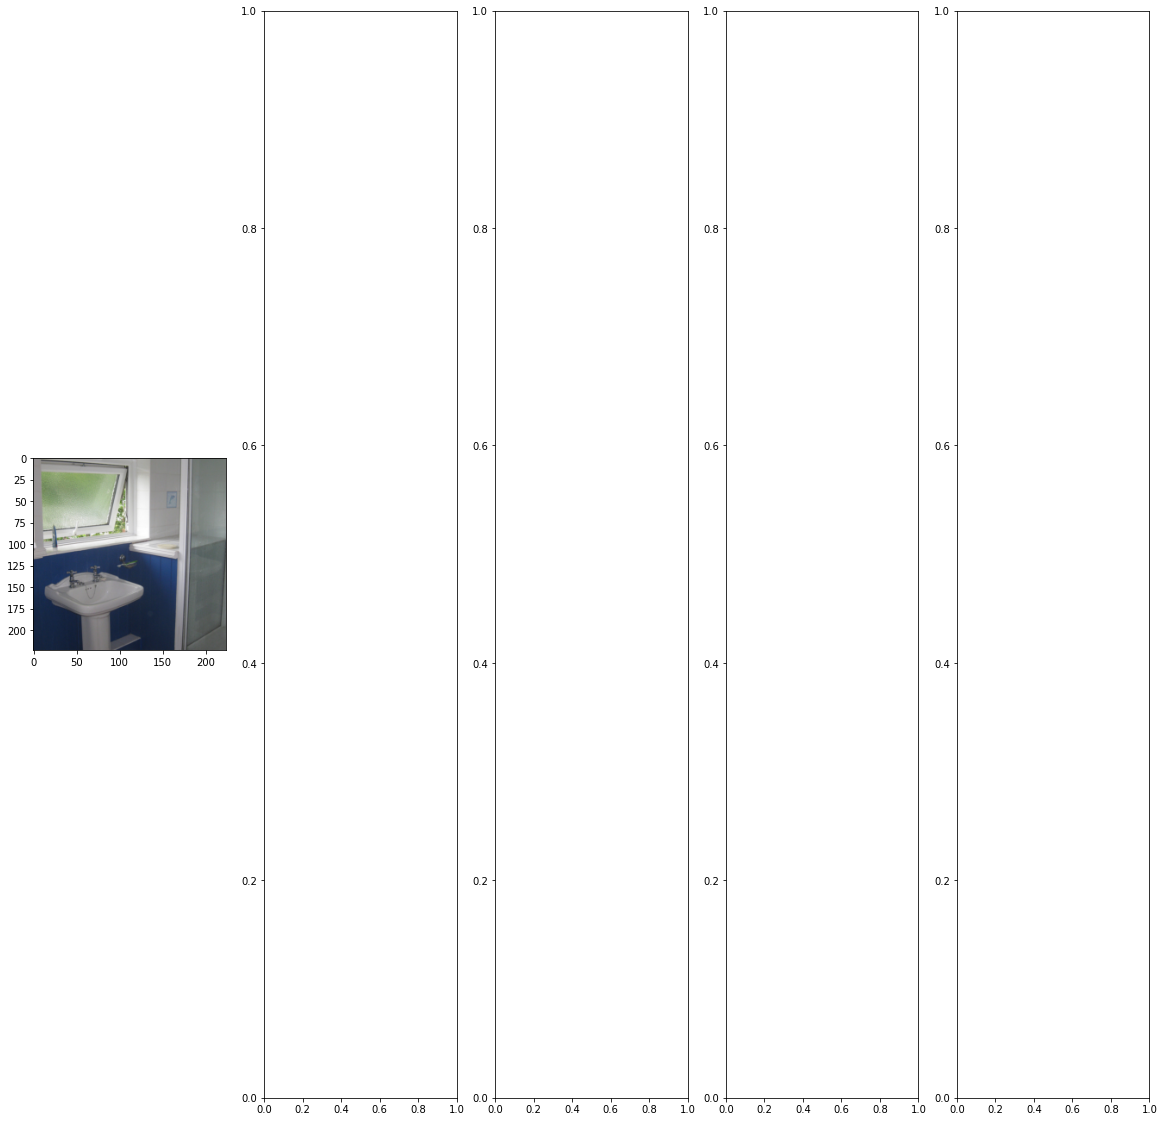

In [ ]:
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                            ])
vcbatch_size = 5
vcheck_dataset = TestDataset(dataset_root,train=False,transform=transform)
vcheck_loader = DataLoader(vcheck_dataset,batch_size=vcbatch_size,shuffle=False,num_workers=4)

for batch, (image, question, annotation) in enumerate(vcheck_loader):
    f, axarr = plt.subplots( 1,vcbatch_size,figsize=(20,20),squeeze=False)
    for j in range(vcbatch_size):
        img = transforms.functional.to_pil_image(image[j])
        axarr[0,j].imshow(img)
        l = next(key for key, value in test_dataset.annotation_map.items() if value == annotation[j].item())
        title = question[j]+":"+l+" ("+str(annotation[j].item())+")"
        axarr[0,j].set_title(title,fontsize=9,color='white')
        axarr[0,j].axis('off')
    plt.show()
    if batch > 4:
      break

In [ ]:
#!cp -rv 'drive/My Drive/aidl/model1000_any' /content/model1000_any/

In [ ]:
#!ls -1 /content/model1000_any/coco | wc -l

In [ ]:
import time
from datetime import timedelta

a = time.time()
time.sleep(2)
b = time.time()

print (str(timedelta(seconds=3750)))


1:02:30
